# Time Serie Analysis - Climate forecasting

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

sns.set(rc={'figure.figsize':(10, 8)})
sns.set_style('darkgrid', {'axes.linewidth': 2, 'axes.edgecolor':'black'})

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [7]:
# Import dataset
df = pd.read_csv(r'dataset\DailyDelhiClimateTrain.csv')
test = pd.read_csv(r'dataset\DailyDelhiClimateTest.csv')

df.head()
# train.dtypes

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [8]:
# Check for any missing dates - None found
# From 2013-01-01    to    2017-01-01
# Only one observation in 2017, thus the last observation is removed.

# df.groupby(pd.PeriodIndex(df['date'], freq="M")).size()

In [9]:
# I would like to look at monthly averages. 
train = df[:-1].groupby(pd.PeriodIndex(df[:-1]['date'], freq="M")).mean();
train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01,12.074770,73.028802,4.833913,1017.847734
2013-02,16.867560,71.938563,7.474090,1015.946003
2013-03,22.814209,57.417243,8.757270,1011.733909
2013-04,28.895119,34.612103,8.046385,1006.292341
2013-05,33.776767,28.938249,8.943452,999.924194


# Initial insight
Let us begin by exploring our variables. 

In [10]:
train.describe()

,meantemp,humidity,wind_speed,meanpressure
count,48.000000,48.000000,48.000000,48.000000
mean,25.479518,60.716376,6.811726,1011.070112
std,7.041301,13.801322,1.987602,34.390560
min,12.074770,28.938249,2.117500,934.847045
25%,18.972184,54.025685,5.423095,1000.542880
50%,28.030655,62.615731,7.260034,1008.816926
75%,31.188816,70.944592,8.541639,1015.501382
max,34.946836,84.572581,10.111250,1227.166990


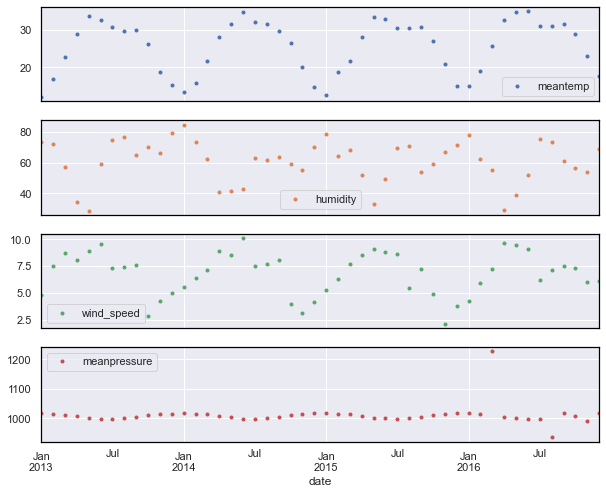

In [11]:
cols_plot = ['meanTemp', 'humidity', 'wind_speed', 'meanpressure']
train.plot(linestyle='None', alpha=1, marker='.', subplots = True);

### Remarks
* Seasionality within meantemp, humidity and wind_speed. 
* Outlier in meanpreassure. Potential outliers in wind_speed.

# 1. Investigating variables

## 1.1 Mean temperature

### 1.1.1 Heat map
Returning the daily values for a second, we can take a quick look into the daily mean temperature with a heat map. As seen in figure below, most of the warmer days reside in the middle of the year.

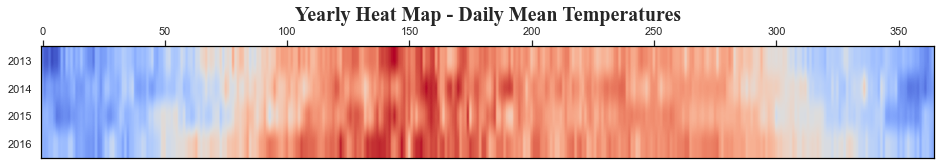

In [12]:
groups = df[:-1].groupby(pd.PeriodIndex(df[:-1]['date'], freq="A"))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.reset_index().meantemp
axs = plt.matshow(years.T, aspect='auto', interpolation=None, cmap=plt.get_cmap('coolwarm'));
plt.grid()
plt.title('Yearly Heat Map - Daily Mean Temperatures', fontname="Times New Roman", size=20, fontweight="bold")
plt.tick_params(axis='x', bottom=False)
plt.yticks(np.arange(4), ["2013", "2014", "2015", "2016"]);

### 1.1.2 Line plot
We have already seen a scatter plot of the monthly mean temperature, but let us plot our observations again and investigate. 

**Observations from the line plot:**
* Strong seasonal pattern.
* Potential trend.
* Non-stationary.

In [13]:
train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01,12.074770,73.028802,4.833913,1017.847734
2013-02,16.867560,71.938563,7.474090,1015.946003
2013-03,22.814209,57.417243,8.757270,1011.733909
2013-04,28.895119,34.612103,8.046385,1006.292341
2013-05,33.776767,28.938249,8.943452,999.924194


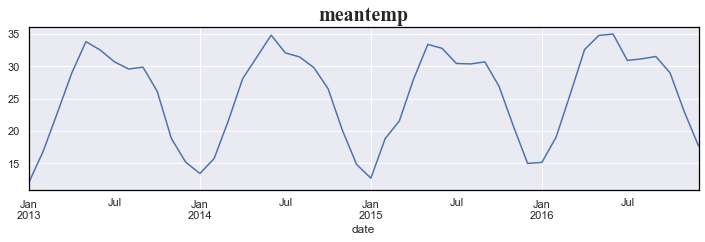

In [14]:
axs = train.loc[:, "meantemp"].plot(figsize=(12, 3));
axs.set_title('meantemp', fontname="Times New Roman", size=20, fontweight="bold");

### 1.1.3 Box-and-whisker plot
We can group our data by both months and year. 

**Observations from figure 1:**
* Strong seasonality.
* Potential outliers or structural breaks.

**Observations from figure 2:**
* No year seem to differ from another significantly. 

Our training period is quite short since we are looking back on 4 years. Longer periods could have had year-to-year fluctuations not being systematic and thus hard to model. For example, climate data from 1980 would probebly not be representative today. These structural breaks could suggest a benefit in dropping initial years of the training data set.

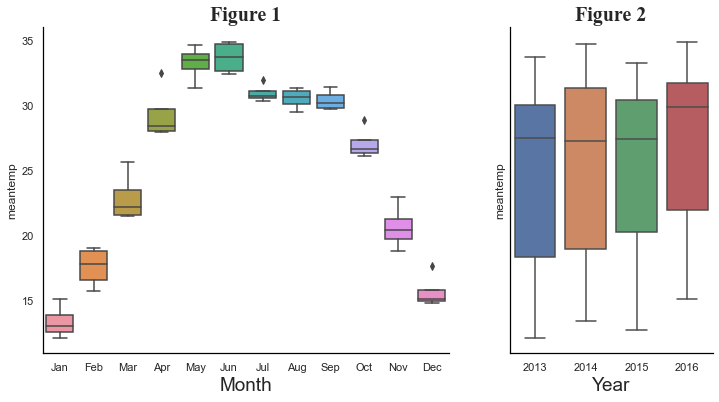

In [15]:
train['Month'] = train.index.strftime('%b')
train['Year'] = train.index.strftime('%Y')

f, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6), gridspec_kw={'width_ratios': [2, 1]})
sns.boxplot(x='Month', y='meantemp', data=train, ax=axs[0])
sns.boxplot(x='Year', y='meantemp', data=train, ax=axs[1])

for i in range(2):
    axs[i].set_facecolor('white')
    axs[i].xaxis.label.set_size(19)
    axs[i].spines.right.set_visible(False)
    axs[i].spines.top.set_visible(False)
    axs[i].set_title(f'Figure {i+1}', fontname="Times New Roman", size=20, fontweight="bold")
    
train = train.drop(columns=['Month', 'Year'])

### 1.1.4 Density plot
Density of our observations could provide knowledge regarding structure. 

**Observations from the KDE plot:**
* The distribution is not Gaussian.
* Distribution is right shifted, may be exponential or double Gaussian.

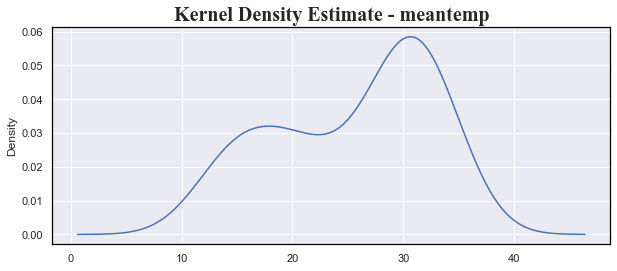

In [16]:
axs = train.loc[:, "meantemp"].plot(kind='kde', figsize=(10, 4))
axs.set_title('Kernel Density Estimate - meantemp', fontname="Times New Roman", size=20, fontweight="bold");

### ACF and PACF

Some observations from the ACF and PACF:
* Clear seasonal pattern in ACF.

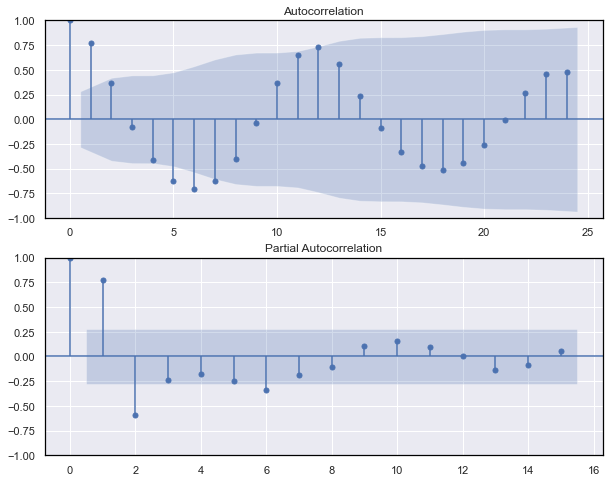

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure()
plt.subplot(211)
plot_acf(train.loc[:, "meantemp"], lags=24, ax=plt.gca());
plt.subplot(212)
plot_pacf(train.loc[:, "meantemp"], lags=15, ax=plt.gca(), method='ywm');

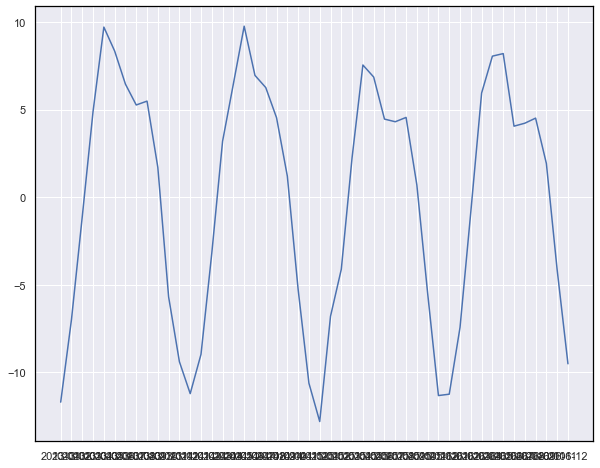

In [18]:
from scipy import signal

temp_d = signal.detrend(train['meantemp'].values)
plt.plot(train.index.strftime('%Y-%m'), temp_d);
#plt.set_title('meantemp', fontname="Times New Roman", size=20, fontweight="bold");

In [19]:
# Seasonal differenced
temp_d12 = np.diff(temp_d, 12)

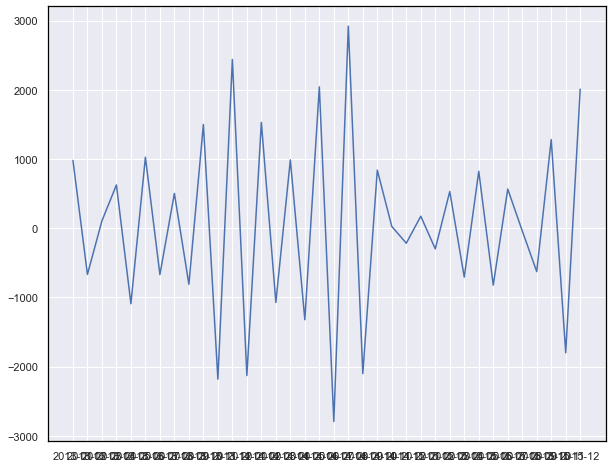

In [20]:
plt.plot(train.index.strftime('%Y-%m')[:-12], temp_d12);

**Augmented Dickey-Fuller Test**

In [26]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(temp_d12, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.194502
p-value: 0.000009


# 2. ARIMA Models

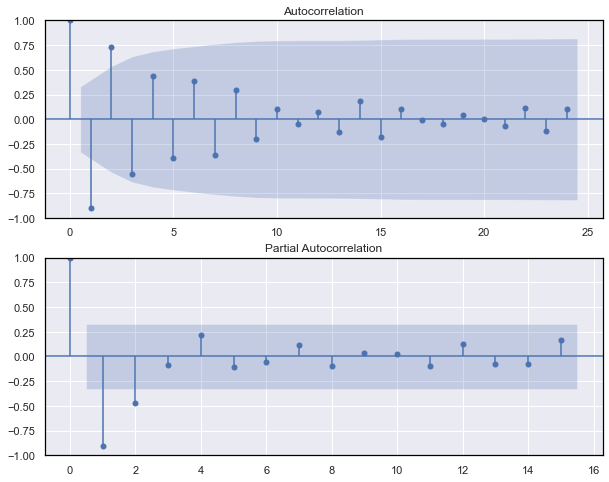

In [27]:
plt.figure()
plt.subplot(211)
plot_acf(temp_d12, lags=24, ax=plt.gca());
plt.subplot(212)
plot_pacf(temp_d12, lags=15, ax=plt.gca(), method='ywm');

### Manually configured ARIMA

**AR terms**: 
Looking at the PACF plot, count number of "lollipops" outside the confidence interval before going inside the interval. Our plot indicate to use 2 AR terms.

**MA terms**: Looking at the ACF plot, count number of "lollipops" outside the confidence interval before going inside the interval. One should also consider harp cut-offs at lag q. Our plot indicate to use 2 MA terms.


In [23]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(temp_d12, order=(1,0,2))
model_fit = model.fit()


fc = model_fit.get_forecast(12)  
conf = fc.conf_int(alpha=0.05) # 95% confidence

fc_series = pd.Series(fc.predicted_mean)
print(fc_series)

0    -1903.798180
1     1720.708307
2    -1576.545773
3     1444.449885
4    -1323.433495
5     1212.544464
6    -1110.958128
7     1017.871217
8     -932.595460
9      854.452556
10    -782.868732
11     717.270590
dtype: float64


C:\Users\andre\venv\ts_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


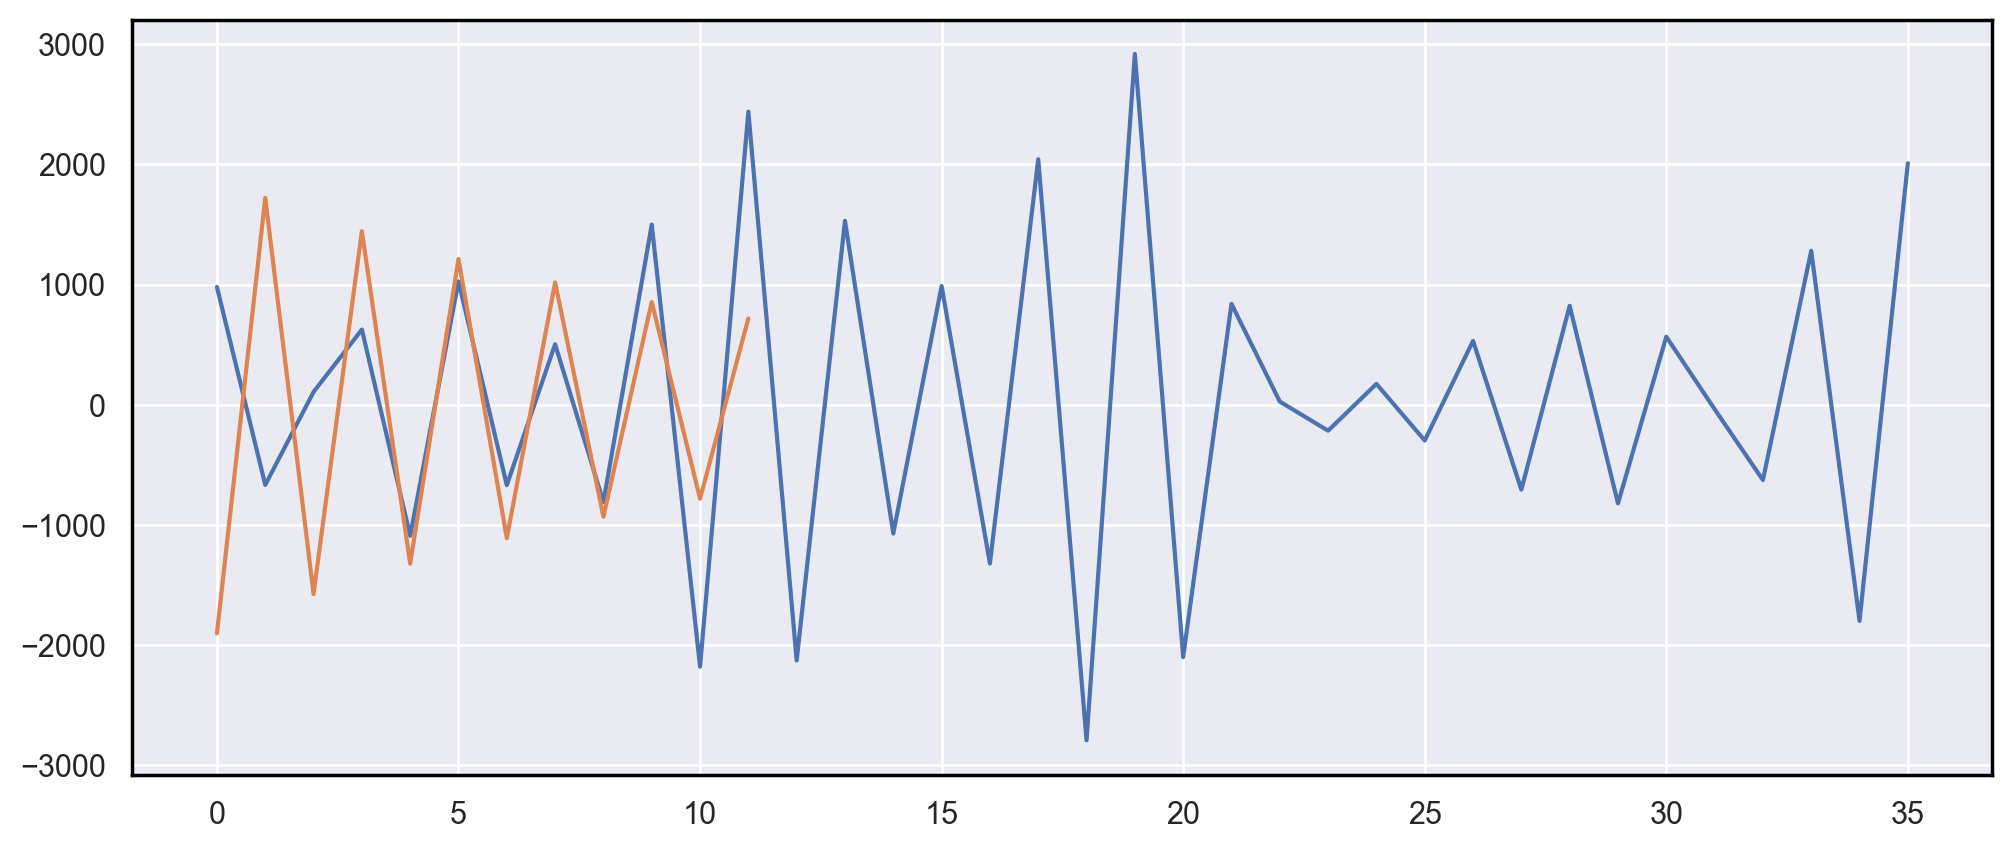

In [24]:
plt.figure(figsize=(12,5), dpi=200)
plt.plot(temp_d12, label='training')
plt.plot(fc_series, label='forecast')